## Prediction models for the U.S. dataset

In [14]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

### 1. data:

We start with loading the cleaned US dataset.

In [2]:
url = https://raw.githubusercontent.com/Vincent2308/Corporate-Bankruptcy/main/data/clean/US/american_cleaned_with_names.csvdf_31 = pd.read_csv(url)

# delete 
df = df_31.drop(columns=["company_name", "fyear", "Division", "bankrupt"])
col = df.pop("Bankrupt")
df.insert(0, "Bankrupt", col)

df.head()

,Bankrupt,current_assets,cost_of_goods_sold,depreciation_amortization,ebitda,inventory,net_income,total_receivables,market_value,net_sales,...,total_liabilities,operating_expenses,MajorGroup,leverage,current_ratio,quick_ratio,roa,ebit_margin,gross_margin,retained_to_assets
0,0,511267.0,740998.000,833107.0,180447.0,18373.00,70658.00,89031.000,191226.00,336.018,...,1024333.000,935302.0,37,6.252948,0.499122,0.481185,0.431325,598.259617,0.381968,0.002275
1,0,485856.0,701.854,713811.0,179987.0,18577.00,45.79,64367.000,160444.00,320.590,...,874255.000,809888.0,37,6.972175,0.555737,0.534488,0.000365,636.529524,359.296921,0.003008
2,0,436656.0,710199.000,526477.0,217699.0,22496.00,4711.00,27207.000,112244.00,286588.000,...,638721.000,611514.0,37,4.245009,0.683641,0.648421,0.031310,0.000487,0.270521,0.002423
3,0,396412.0,686.621,496747.0,164658.0,27172.00,3573.00,30745.000,109.59,259954.000,...,606337.000,575592.0,37,2.978445,0.653782,0.608968,0.017551,0.477415,0.255130,0.000704
4,0,432204.0,709.292,523302.0,248666.0,26.68,20811.00,47.491,128656.00,247245.000,...,651.958,604467.0,37,0.004967,662.932275,662.891352,0.158547,0.533414,0.423309,0.002353


### 2. Splitting the dataset

Next we need to split the dataset into a training and test dataset. This is to make sure any model we make doesn't only work for the specific dataset we've used to make the model. We will use a 80/20 split for the training and testing dataset respectfully, the reasoning for this is specified in the Polish model notebook.

In [3]:
y = df["Bankrupt"]
X = df.drop(columns=["Bankrupt"])

X.isna().sum().sort_values(ascending=False).head(10)
df[["gross_margin", "ebit_margin", "net_sales"]].describe()

,gross_margin,ebit_margin,net_sales
count,58981.000000,58981.000000,5.898100e+04
mean,427.657385,-2911.539928,5.911116e+04
std,1896.859655,19599.437274,1.598647e+05
min,0.000000,-163781.051978,2.084000e-01
25%,0.424252,-6.644493,2.553000e+02
50%,1.216747,0.005770,3.668000e+03
75%,4.979695,3.236016,3.467300e+04
max,15181.554754,17081.114237,1.108389e+06


The original U.S. dataset did not contain any explicit missing values after the initial cleaning provided in the assignment. However, once financial ratio variables (e.g., gross margin, EBIT margin, retained-to-assets) were constructed, approximately 25% of observations became missing.
This missingness is expected because ratio variables often involve denominators such as net sales or total assets, which may be zero or unavailable for certain firms.

To avoid unnecessary sample loss and to maintain model stability, we applied median imputation to these ratio variables. Median imputation is appropriate for highly skewed accounting ratios and is commonly used in financial modeling.

In [4]:
X = X.fillna(X.median())
X.isna().sum().sort_values(ascending=False).head(10)

current_assets        0
cost_of_goods_sold    0
gross_margin          0
ebit_margin           0
roa                   0
quick_ratio           0
current_ratio         0
leverage              0
MajorGroup            0
operating_expenses    0
dtype: int64

In [5]:
# Split the dataset

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### 3. Scaling
Next we will scale the data so all values in the collumns have mean 0 and a standard deviation of 1. We do this because some collumns have a much bigger range of values than others, these could disproportionality affact the model compared to collumns that have a smaller values. 

We only have to scale the *x* dataset because y are binairy values (0 for in business and 1 for bankrupt)

In [6]:
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

### 4. SMOTE

In [7]:
smote = SMOTE(random_state = 42)
X_train_sc_sm, y_train_sm, = smote.fit_resample(X_train_sc, y_train)

### 5. Evaluation

In [8]:
def evaluate_model(model, X_test_sc, y_test):
    # evaluate the mdodel based on the previoulsy chosen metrics
    y_pred = model.predict(X_test_sc)

    # get the predicted probability the the sample belongs to Bankrupt = 1
    y_prob = model.predict_proba(X_test_sc)[:,1]

    # metrics
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    auc = roc_auc_score(y_test, y_prob)

    # print results
    print(f'Accuracy: {acc:.3f}')
    print(f'Precision: {pre:.3f}')
    print(f'Recall: {rec:.3f}')
    print(f'F1-Score: {f1:.3f}')
    print(f'AUC Score: {auc:.3f}')

    # plot
    RocCurveDisplay.from_estimator(model, X_test_sc, y_test)
    plt.show()

### 6. Altman Z-score

Because the U.S. dataset does not include Taiwan-specific accounting ratios used in the original Altman Z-score model, we reconstructed the Z-score using the classical five-factor Altman formula with variables available in the U.S. financial statements.

In [9]:
df["X1"] = (df["current_assets"] - df["current_liabilities"]) / df["total_assets"]
df["X2"] = df["retained_earnings"] / df["total_assets"]
df["X3"] = df["ebit"] / df["total_assets"]
df["X4"] = df["market_value"] / df["total_liabilities"]
df["X5"] = df["net_sales"] / df["total_assets"]

df["Z_score"] = (
    1.2 * df["X1"] +
    1.4 * df["X2"] +
    3.3 * df["X3"] +
    0.6 * df["X4"] +
    1.0 * df["X5"]
)

df["Z_score"] = df["Z_score"].fillna(df["Z_score"].median())
auc_z = roc_auc_score(df["Bankrupt"], df["Z_score"])
auc_z

0.4266266248528835

### 8. Logistic Regression

##### 8.1 without SMOTE

Accuracy: 0.545
Precision: 0.088
Recall: 0.625
F1-Score: 0.154
AUC Score: 0.639


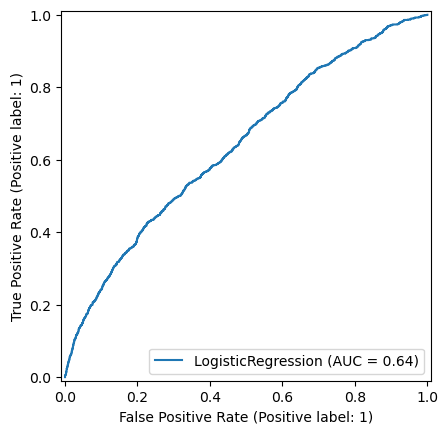

In [10]:
lr = LogisticRegression(max_iter = 1000, class_weight = "balanced")
lr.fit(X_train_sc, y_train)
evaluate_model(lr, X_test_sc, y_test)

##### 8.2 Higher max iter

Accuracy: 0.545
Precision: 0.088
Recall: 0.625
F1-Score: 0.154
AUC Score: 0.639


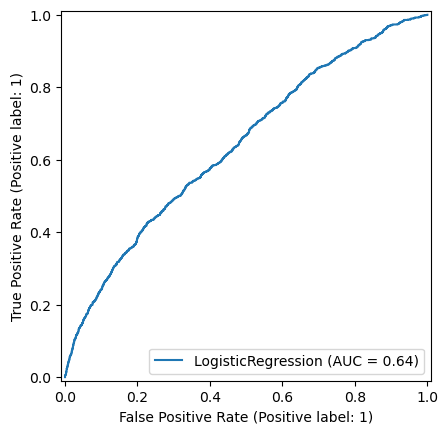

In [11]:
lr = LogisticRegression(max_iter = 500000, class_weight = "balanced")
lr.fit(X_train_sc, y_train)
evaluate_model(lr, X_test_sc, y_test)

##### 8.3 with SMOTE

Accuracy: 0.541
Precision: 0.088
Recall: 0.633
F1-Score: 0.155
AUC Score: 0.641


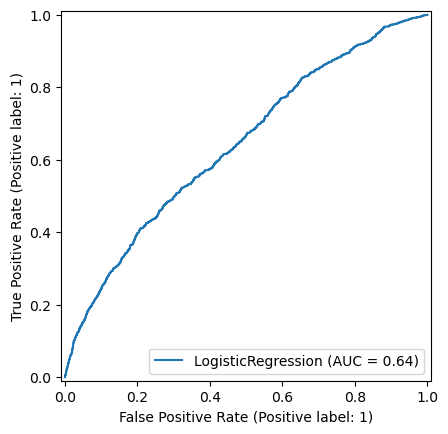

In [12]:
lr_sm = LogisticRegression(max_iter = 999999)
lr_sm.fit(X_train_sc_sm, y_train_sm)
evaluate_model(lr_sm, X_test_sc, y_test)

##### 8.4 Principal Component Analysis (PCA)

Accuracy: 0.934
Precision: 0.000
Recall: 0.000
F1-Score: 0.000
AUC Score: 0.508


/opt/anaconda3/envs/sda-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


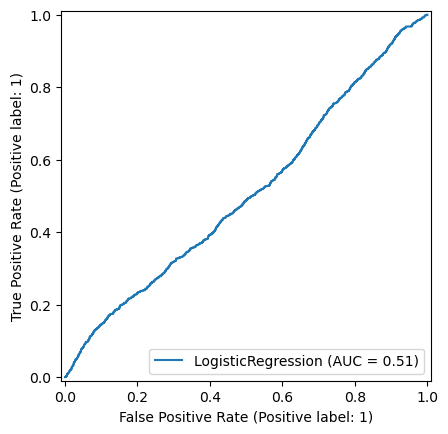

In [15]:
pca = PCA(n_components=1)
X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca  = pca.transform(X_test_sc)

lr_pca = LogisticRegression()
lr_pca.fit(X_train_pca, y_train)
evaluate_model(lr_pca, X_test_pca, y_test)

##### 8.5 Principal Component Analysis (PCA) with SMOTE

Accuracy: 0.279
Precision: 0.067
Recall: 0.761
F1-Score: 0.123
AUC Score: 0.500


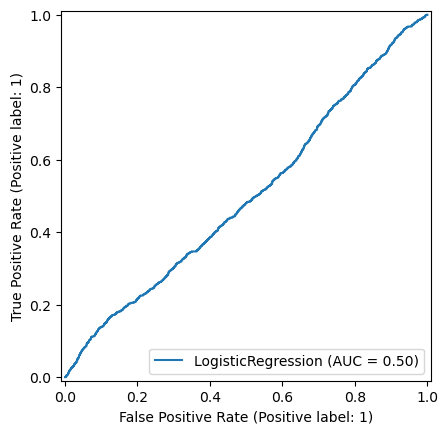

In [17]:
pca = PCA(n_components=1)
X_train_pca = pca.fit_transform(X_train_sc_sm)
X_test_pca = pca.transform(X_test_sc)

lr_pca_sm = LogisticRegression()
lr_pca_sm.fit(X_train_pca, y_train_sm)
evaluate_model(lr_pca_sm, X_test_pca, y_test)

### 9. Random forrest

##### 9.1 Random forrest without SMOTE

Accuracy: 0.935
Precision: 0.846
Recall: 0.021
F1-Score: 0.041
AUC Score: 0.832


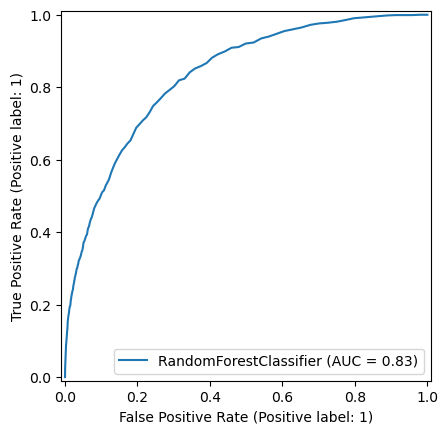

In [18]:
rf = RandomForestClassifier(n_estimators = 500, class_weight = "balanced", random_state = 42)
rf.fit(X_train_sc, y_train)
evaluate_model(rf, X_test_sc, y_test)

##### 9.2 Random forrest with SMOTE

Accuracy: 0.902
Precision: 0.236
Recall: 0.211
F1-Score: 0.223
AUC Score: 0.751


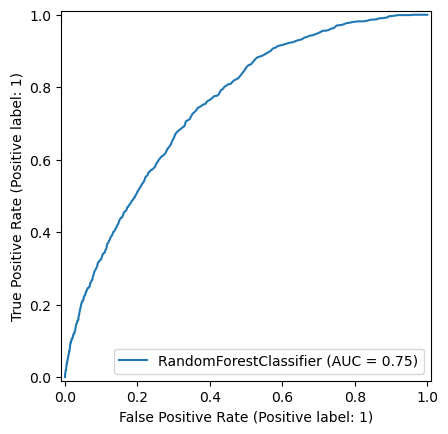

In [20]:
rf_sm = RandomForestClassifier(n_estimators=500, random_state=42)
rf_sm.fit(X_train_sc_sm, y_train_sm)
evaluate_model(rf_sm, X_test_sc, y_test)

##### 9.3 Random forrest with Linear Discriminant Analysis (LDA) and SMOTE

Accuracy: 0.539
Precision: 0.079
Recall: 0.554
F1-Score: 0.138
AUC Score: 0.577


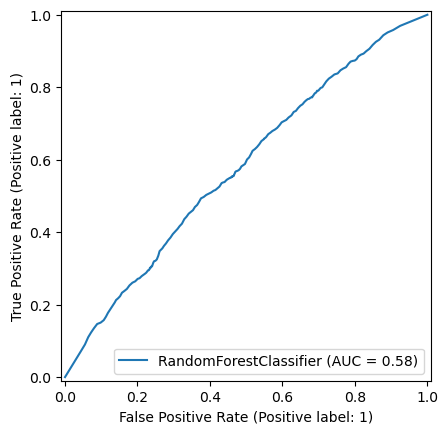

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# LDA after SMOTE
lda = LinearDiscriminantAnalysis(n_components=1)
X_train_lda_sm = lda.fit_transform(X_train_sc_sm, y_train_sm)
X_test_lda = lda.transform(X_test_sc)

rf_sm_lda = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_sm_lda.fit(X_train_lda_sm, y_train_sm)
evaluate_model(rf_sm_lda, X_test_lda, y_test)

##### 9.4 Random forrest with Linear Discriminant Analysis (LDA)

Accuracy: 0.876
Precision: 0.088
Recall: 0.093
F1-Score: 0.091
AUC Score: 0.548


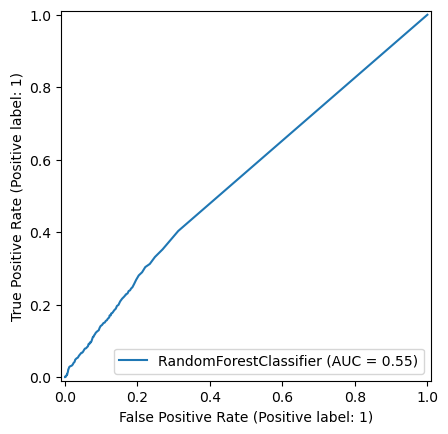

In [23]:
lda = LinearDiscriminantAnalysis(n_components=1)
X_train_lda = lda.fit_transform(X_train_sc, y_train)
X_test_lda  = lda.transform(X_test_sc)

rf_lda = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_lda.fit(X_train_lda, y_train)
evaluate_model(rf_lda, X_test_lda, y_test)

### 10. K nearest neighbours

##### 10.1 without SMOTE

Accuracy: 0.928
Precision: 0.403
Recall: 0.167
F1-Score: 0.236
AUC Score: 0.658


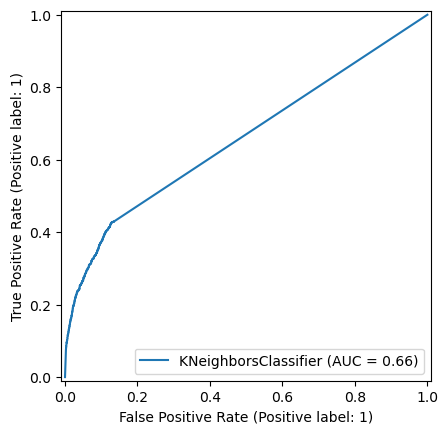

Accuracy: 0.934
Precision: 1.000
Recall: 0.001
F1-Score: 0.002
AUC Score: 0.738


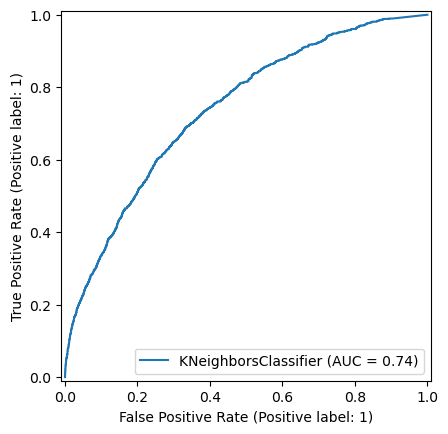

In [25]:
#----------Manual implementation of KNN----------
def evaluate_knn(preds, probs, y_test):
    acc = accuracy_score(y_test, preds)
    pre = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    auc = roc_auc_score(y_test, probs)

    print(f"Accuracy: {acc:.3f}")
    print(f"Precision: {pre:.3f}")
    print(f"Recall: {rec:.3f}")
    print(f"F1-Score: {f1:.3f}")
    print(f"AUC Score: {auc:.3f}")

    RocCurveDisplay.from_predictions(y_test, probs)
    plt.show()

def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((np.array(point1) - np.array(point2))**2))

def knn_predict_one_with_prob(training_data, training_labels, test_point, k):
    distances = []
    for i in range(len(training_data)):
        dist = euclidean_distance(test_point, training_data[i])
        distances.append((dist, training_labels[i]))

    distances.sort(key=lambda x: x[0])
    k_nearest_labels = [label for _, label in distances[:k]]

    counter = Counter(k_nearest_labels)
    prob_1 = counter[1] / k

    pred = 1 if prob_1 >= 0.5 else 0
    return pred, prob_1

def knn_predict_many_with_prob(training_data, training_labels, test_data, k):
    preds = []
    probs = []
    for point in test_data:
        pred, prob = knn_predict_one_with_prob(training_data, training_labels, point, k)
        preds.append(pred)
        probs.append(prob)
    return np.array(preds), np.array(probs)

# for k in [1,3,5,7,25, 31, 41, 51]:
#     preds, probs = knn_predict_many_with_prob(x_train_sc_sm, y_train_sm, x_test_sc, k=10)
#     evaluate_knn(preds, probs, y_test)


#----------sklearn implementation of KNN----------
from sklearn.neighbors import KNeighborsClassifier

knn = {}
for k in [3, 99]:
    model = KNeighborsClassifier(n_neighbors=k, weights='distance', n_jobs=-1)
    model.fit(X_train_sc, y_train)
    knn[str(k)] = model
    evaluate_model(knn[str(k)], X_test_sc, y_test)

### 10.2 KNN with SMOTE

Accuracy: 0.811
Precision: 0.176
Recall: 0.503
F1-Score: 0.261
AUC Score: 0.697


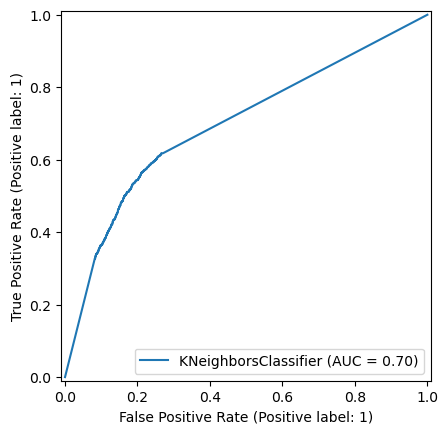

Accuracy: 0.614
Precision: 0.116
Recall: 0.729
F1-Score: 0.200
AUC Score: 0.744


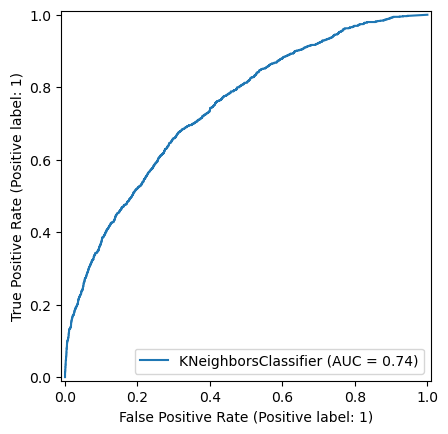

In [26]:
knn_sm = {}
for k in [3, 99]:
    model = KNeighborsClassifier(n_neighbors=k, weights='distance', n_jobs=-1)
    model.fit(X_train_sc_sm, y_train_sm)
    knn_sm[str(k)] = model
    evaluate_model(knn_sm[str(k)], X_test_sc, y_test)

### 11. XGBoost

Accuracy: 0.937
Precision: 0.654
Recall: 0.114
F1-Score: 0.194
AUC Score: 0.818


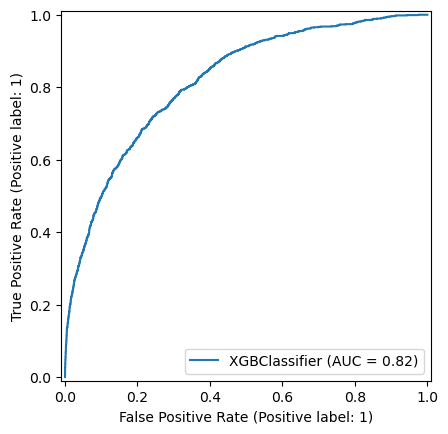

In [27]:
xgb = XGBClassifier(eval_metric = "logloss", random_state = 42)
xgb.fit(X_train_sc, y_train)
evaluate_model(xgb, X_test_sc, y_test)

Accuracy: 0.874
Precision: 0.207
Recall: 0.316
F1-Score: 0.250
AUC Score: 0.741


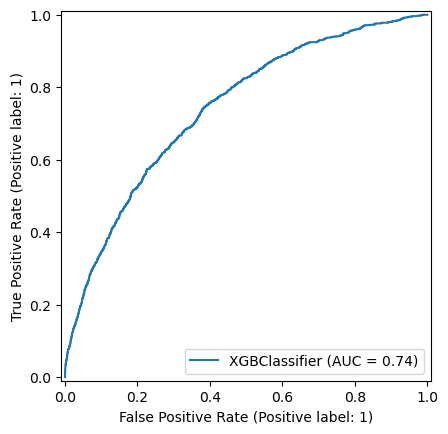

In [28]:
xgb_sm = XGBClassifier(eval_metric = "logloss", random_state = 42)
xgb_sm.fit(X_train_sc_sm, y_train_sm)
evaluate_model(xgb_sm, X_test_sc, y_test)

### 12. Features

In [30]:
coefficients = lr.coef_[0]
odds_ratios = np.exp(coefficients)

coefficients_df = pd.DataFrame({
'Feature' : X.columns,
"Coefficients" : coefficients,
"Odds ratio" : odds_ratios
})

print(coefficients_df.sort_values(by="Coefficients", ascending=False))
coefficients_df.head(15)

                      Feature  Coefficients  Odds ratio
20              current_ratio      0.260289    1.297304
4                   inventory      0.138800    1.148894
15              total_revenue      0.128362    1.136965
3                      ebitda      0.115772    1.122740
9                total_assets      0.105655    1.111438
6           total_receivables      0.055208    1.056760
17         operating_expenses      0.051950    1.053323
2   depreciation_amortization      0.050840    1.052154
7                market_value      0.044172    1.045162
19                   leverage      0.035151    1.035776
24               gross_margin     -0.014827    0.985282
13        current_liabilities     -0.017782    0.982376
16          total_liabilities     -0.017782    0.982376
22                        roa     -0.033440    0.967113
23                ebit_margin     -0.042676    0.958222
8                   net_sales     -0.056720    0.944859
1          cost_of_goods_sold     -0.059131    0

,Feature,Coefficients,Odds ratio
0,current_assets,-0.272713,0.761311
1,cost_of_goods_sold,-0.059131,0.942583
2,depreciation_amortization,0.050840,1.052154
3,ebitda,0.115772,1.122740
4,inventory,0.138800,1.148894
5,net_income,-0.078457,0.924542
6,total_receivables,0.055208,1.056760
7,market_value,0.044172,1.045162
8,net_sales,-0.056720,0.944859
9,total_assets,0.105655,1.111438


In [32]:
fi_rf = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

fi_rf.head(15)

MajorGroup                   0.069241
long_term_debt               0.054555
retained_to_assets           0.048931
ebit                         0.045632
retained_earnings            0.045632
total_revenue                0.038450
roa                          0.038437
inventory                    0.037039
current_assets               0.036772
gross_profit                 0.036707
market_value                 0.036675
quick_ratio                  0.036552
ebitda                       0.036301
depreciation_amortization    0.036273
net_income                   0.035790
dtype: float64

In [33]:
fi_xgb = pd.Series(xgb.feature_importances_,index=X.columns).sort_values(ascending=False)

fi_xgb.head(15)

MajorGroup             0.078069
long_term_debt         0.062443
retained_to_assets     0.048027
ebitda                 0.046659
retained_earnings      0.045507
ebit                   0.041513
ebit_margin            0.040309
market_value           0.039747
total_receivables      0.039271
net_sales              0.039104
quick_ratio            0.039016
total_revenue          0.036759
gross_margin           0.036074
current_liabilities    0.035903
net_income             0.035686
dtype: float32

### 13. Compare models

In [35]:
results = []

def add_result(name, model, data):
    # evaluate the mdodel based on the previoulsy chosen metrics
    y_pred = model.predict(data)

    # gets the predicted probability the the sample belongs to Bankrupt = 1
    y_prob = model.predict_proba(data)[:,1]

    results.append({"Model": name,"Auc": roc_auc_score(y_test, y_prob),
        "Recall": recall_score(y_test, y_pred),"Precision": precision_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred)
    })

In [39]:
add_result("Logistic regression", lr, X_test_sc)
add_result("Logistic regression (SMOTE)", lr_sm, X_test_sc)

add_result("RandomForest", rf, X_test_sc)
add_result("RandomForest (SMOTE)", rf_sm, X_test_sc)

add_result("XGBoost", xgb, X_test_sc)
add_result("XGBoost (SMOTE)", xgb_sm, X_test_sc)

add_result("KNN k=3", knn_sm["3"], X_test_sc)
add_result("KNN k=3 (SMOTE)", knn_sm["3"], X_test_sc)

add_result("KNN k=99", knn["99"], X_test_sc)
add_result("KNN k=99 (SMOTE)", knn_sm["99"], X_test_sc)

add_result("Logistic regression PCA", lr_pca, X_test_lda)
add_result("Logistic regression PCA (SMOTE)", lr_pca_sm, X_test_lda)

add_result("Random forrest LDA", rf_lda, X_test_lda)
add_result("Random forrest LDA (SMOTE)", rf_sm_lda, X_test_lda)


/opt/anaconda3/envs/sda-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [40]:
results_df = pd.DataFrame(results)
results_df

,Model,Auc,Recall,Precision,F1
0,Logistic regression,0.638586,0.624521,0.087788,0.153937
1,Logistic regression (SMOTE),0.640524,0.633142,0.088145,0.154747
2,RandomForest,0.831846,0.021073,0.846154,0.041121
3,RandomForest (SMOTE),0.750911,0.210728,0.236052,0.222672
4,Logistic regression,0.638586,0.624521,0.087788,0.153937
5,Logistic regression (SMOTE),0.640524,0.633142,0.088145,0.154747
6,RandomForest,0.831846,0.021073,0.846154,0.041121
7,RandomForest (SMOTE),0.750911,0.210728,0.236052,0.222672
8,XGBoost,0.817722,0.113985,0.653846,0.194127
9,XGBoost (SMOTE),0.741165,0.316092,0.206897,0.250095
